In [1]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns

In [2]:
dataDir="./datasets/"
datasets=[
    "adult",
    "airport",
    "flights",
    "food",
    "Hospital",
    "inspection",
    "ncvoter",
    "SPStock",
    "tax500k",
]

In [3]:
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [4]:
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]

In [6]:
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))

# Code

## Dataset

In [7]:
class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types=[typeMap[match[2]] for match in self.header]
        
        self.df=pd.read_csv(file,dtype={col:type for col,type in zip(self.columns,self.types)},**args)
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

## DenialConstraintResult

In [8]:
class Operator:
    def __init__(self,func,expFunc) -> None:
        self.func=func
        self.expFunc=expFunc
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return self.func.__name__
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    return np.sum(probs**2)-1/len(l)
   

eq=Operator(operator.eq,eqExp)

def neExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    return 1-np.sum(probs**2)
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(1-cumProbs+probs))-1/len(l)
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(cumProbs))-1/len(l)
le=Operator(operator.le,leExp)

def gtExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(1-cumProbs))
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(cumProbs-probs))
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}



class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
    def eval(self,df,t0,t1):
        return self.op(t0[self.l],t1[self.r])
    def expected(self,df):
        if self.exp is None:
            self.exp=self.op.expected(df.df[self.l],None)
        return self.exp
            
    
    def __repr__(self) -> str:
        return '"'+self.l +'" '+self.op.__repr__()+' "'+self.r+'"'
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
    def eval(self,df,t0,t1):
        return sum([pred.eval(df,t0,t1) for pred in self.preds])
    def coverage(self,df,t0s,t1s):
        pos,neg=0,0
        num=self.eval(df,t0s,t1s)
        dclen=len(self.preds)
        pos=(num==dclen).sum()
        neg=(num<dclen).sum()

                
        return neg/(pos+neg)
    def sampleCoverage(self,df,n=None):
        nn=len(df.df)
        if n is None:
            n=nn**2
        t0s = np.random.randint(0,len(df.df),n)
        t1s = np.random.randint(0,len(df.df),n)
        t1s=(t1s+(t1s==t0s)*np.random.randint(1,len(df.df),n))%len(df.df)
        return self.coverage(df,t0s,t1s)
    def expCoverage(self,df):
        return 1-np.prod([pred.expected(df) for pred in self.preds])
    def __repr__(self) -> str:
        return "!["+" & ".join([pred.__repr__() for pred in self.preds])+"]"


class DenialConstraintSet:
    def __init__(self,path,dataset,algorithm) -> None:        
        self.predicates={}
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            if (c1,c2,op) not in self.predicates:
                self.predicates[(c1,c2,op)]=Predicate(c1,opmap[op],c2)
            return self.predicates[(c1,c2,op)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred).groups()) for pred in preds]
                self.DCs.append(DenialConstraint(preds))


# Result generation

## Discover DCs

In [9]:
for dataset in datasets:
    for algorithm in algorithms:
        for aprox in ["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]:
            print("RUN: {}_{}_{}".format(algorithm,dataset,aprox))
            command='java -Xmx8g -jar {} {} {} 100'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox)
            result = subprocess.run(command, shell=True)
            print("MOVE: {}_{}_{}".format(algorithm,dataset,aprox))
            command='mv output.txt results/{}_{}_{}'.format(algorithm,dataset,aprox)
            result = subprocess.run(command, shell=True)

RUN: FastDC_adult_0.00
13:01:11.803 [main] INFO  de.hpi.naumann.dc.input.Input - rebuild: 2
13:01:20.317 [main] INFO  d.h.n.d.c.FastDCMinimalCoverSearch - Building DCs ...

Lines written to file successfully!
MOVE: FastDC_adult_0.00
RUN: Hydra_adult_0.00
13:01:51.490 [main] INFO  d.h.n.dc.algorithms.hybrid.Hydra - Building approximate evidence set...
13:01:51.537 [main] INFO  d.h.n.dc.algorithms.hybrid.Hydra - Estimation size systematic sampling:1323
13:01:51.555 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column age int
13:01:51.582 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column workclass str
13:01:51.585 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column fnlwgt int
13:01:51.587 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column education str
13:01:51.589 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column Education-num int
13:01:51.591 [main] INFO  d.h.n.d.e.b.s.

KeyboardInterrupt: 

## Compute support on random samples

In [10]:
#FROM: https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, axe,title,aproxs,sups,labels=None,  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for ii,i in enumerate(range(0, n_df * n_col, n_col)): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch("" if  sups[j]<=float(aproxs[ii]) else "") #edited part     
                rect.set_width(0.9 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

In [12]:
#FROM: https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_clustered_stacked(dfall, axe,title,aproxs,sups,labels=None,  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for ii,i in enumerate(range(0, n_df * n_col, n_col)): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                #rect.set_hatch(H if  sups[j]<=float(aproxs[ii]) else "") #edited part    
                rect.set_facecolor('r' if  sups[j]<=float(aproxs[ii]) else "g") #edited part   
                rect.set_hatch(H*ii) #edited part     
                
                rect.set_width(0.9 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)


    l1 = axe.legend(handles=[mpatches.Patch( facecolor='w',alpha=0.6,hatch=H*i,label=aproxs[i]) for i in range(n_df)], loc=[1.01, 0.5],title="Aprox. Factor")

    axe.add_artist(l1)
    return axe

In [6]:
#load datasets
dss={}
for dataset in datasets:
    print(dataset)
    dss[dataset]=Dataset(dataDir+dataset+".csv",nrows=20000,encoding='unicode_escape')
    dss[dataset].buildPLIs()

adult
airport
flights
food
Hospital
inspection
ncvoter
SPStock
tax500k


In [ ]:
results={}
for algorithm in algorithms[:1]:
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]
    for aprox in aproxs:
        for dataset in ["atom"]:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
            n=10000
            
            t0s=dss[dataset].randFields(n)
            t1s=dss[dataset].randFields(n)
            res=[]
            for dc in dcs.DCs:
                sup=dc.coverage(dcs,t0s,t1s)
                res.append(sup)
            results[(algorithm,dataset,aprox)]=res


In [7]:
import json
with open("results/DCSups.json") as f:
    results=json.load(f)

In [177]:
algDf={}
DCsups={}
for algorithm in algorithms:
    dfs=[]
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]
    sups=np.array(supports)
    for aprox in aproxs:
        df={}
        for dataset in datasets:
            key="_".join([algorithm,dataset,aprox])
            res=results[key]
            

            counts=np.zeros_like(sups)
            for sup in res:
                sup=sup
                counts+=1-sup<=sups
            DCsups[key]=counts/len(res)
            counts[1:]=counts[1:]-counts[:-1]

            
            
            df[dataset]=counts/counts.sum()
        dfs.append(pd.DataFrame(df,index=[sups]).transpose())
    algDf[algorithm]=dfs

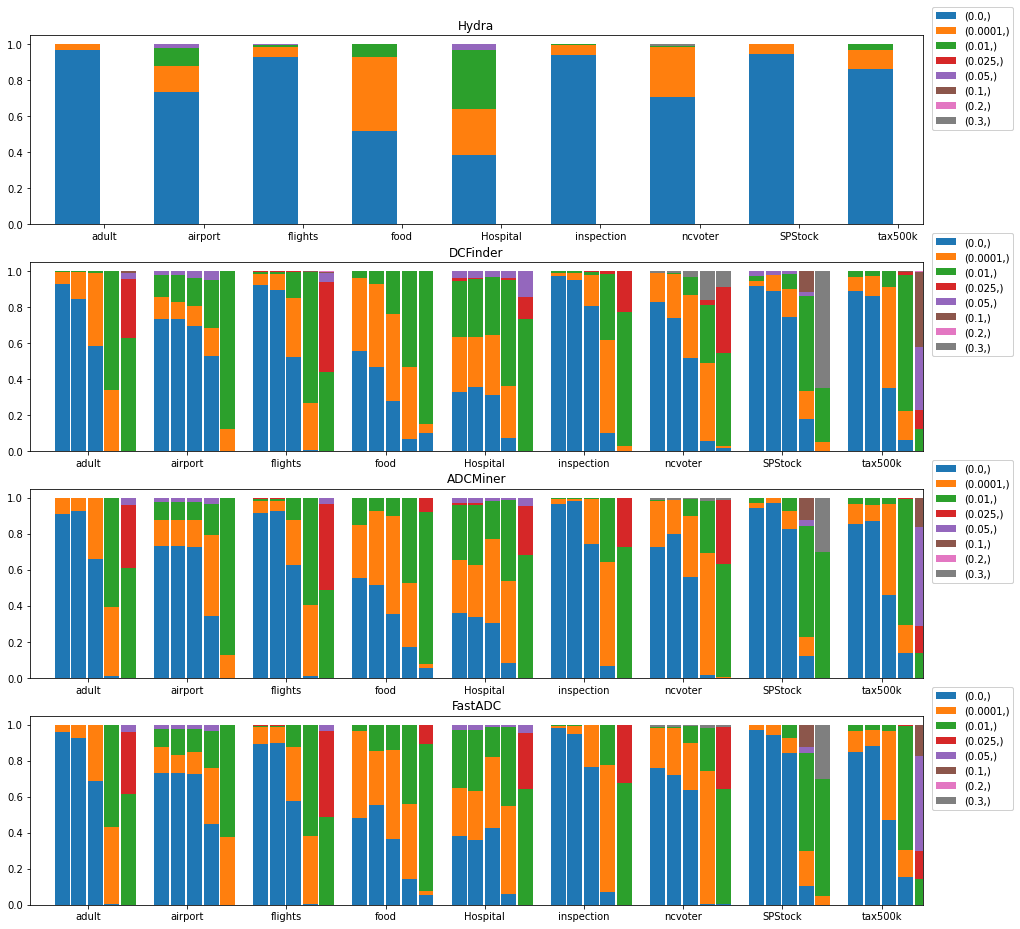

In [11]:
fig,ax=plt.subplots(4,1)
for i,algorithm in enumerate(algorithms):
    plot_clustered_stacked(algDf[algorithm],ax[i],algorithms[i],aproxs,sups,figsize=(16,16))


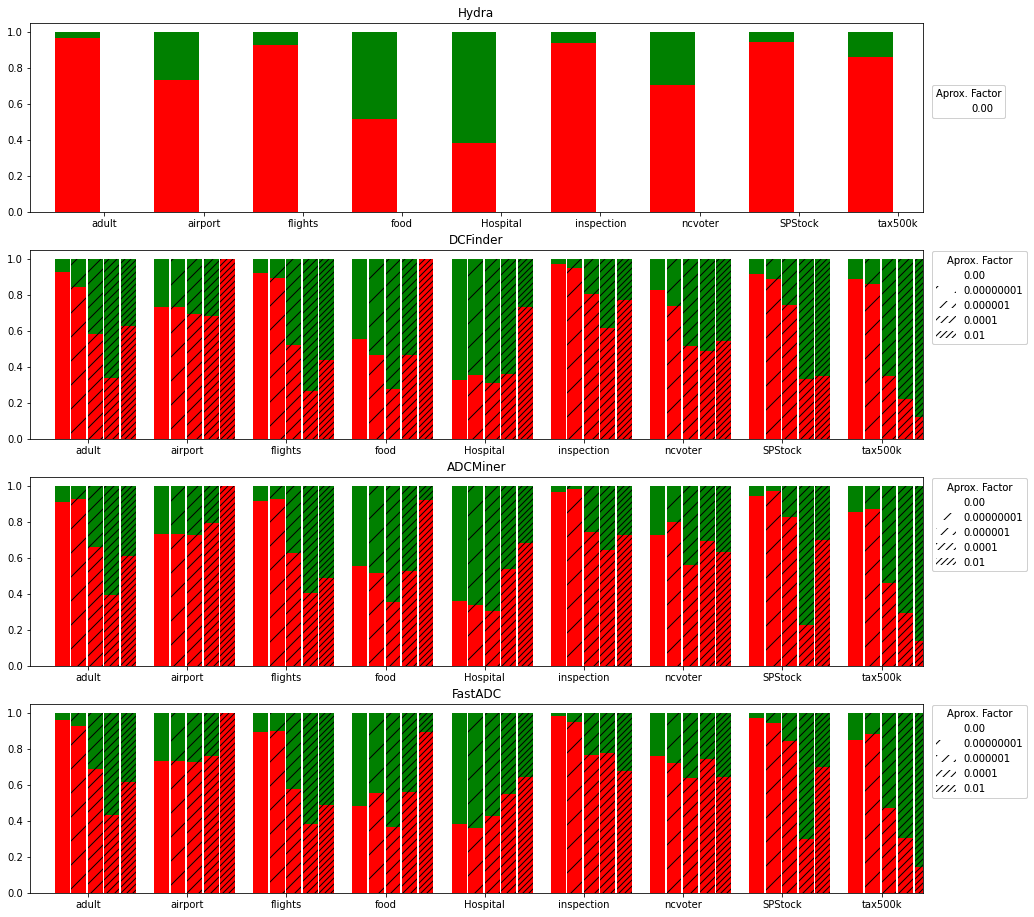

In [13]:
fig,ax=plt.subplots(4,1)
for i,algorithm in enumerate(algorithms):
    plot_clustered_stacked(algDf[algorithm],ax[i],algorithms[i],aproxs,sups,figsize=(16,16))


In [183]:
width=13
height=2
yspace=2
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+=tikzLegend(width+1.4,-(height +yspace)*(len(algorithms)-1) - height)
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node at ({x+width/2},{y+height+0.3}) {{ \\small {algorithms[a]} }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a]!='Hydra' else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a]!='Hydra' else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/len(aproxs) * (t-len(aproxs)//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height}) rectangle ({x+barwidth},{y0+sup[s]*height});\n"
        ss=s
        y=sup[s]
    res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left,draw] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (0.7222222222222222,-2) rectangle (0.8922222222222222,-0.06976744186046502);
\definecolor{mycolor}{hsb}{0.40049950049950056,1,1};
\fill[mycolor] (0.7222222222222222,-0.06976744186046502) rectangle (0.8922222222222222,-0.023255813953488413);
\definecolor{mycolor}{hsb}{0.4308691308691309,1,1};
\fill[mycolor] (0.7222222222222222,-0.023255813953488413) rectangle (0.8922222222222222,0.0);
\node[anchor=west,rotate=-90] at (0.8072222222222222,-2.02) { \tiny $0$ };
\node at (0.7222222222222222,-3) { \small adult };
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (2.1666666666666665,-2) rectangle (2.3366666666666664,-0.5714285714285714);
\definecolor{mycolor}{hsb}{0.47002997002997005,1,1};
\fill[mycolor] (2.1666666666666665,-0.5714285714285714) rectangle (2.3366666666666664,-0.5238095238095237);
\definecolor{mycolor}{hsb}{0.49080919080919083,1,1};
\fill[mycolor] (2.1666666666666665,-0.5238095238095237) rectangle (2.3366

In [187]:
width=13
height=2
yspace=2
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node at ({x+width/2},{y+height+0.3}) {{ \\small {algorithms[a]} }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a]!='Hydra' else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a]!='Hydra' else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/len(aproxs) * (t-len(aproxs)//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height}) rectangle ({x+barwidth},{y0+sup[s]*height});\n"
        ss=s
        y=sup[s]
    res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left,draw] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (0.7222222222222222,-2) rectangle (0.8922222222222222,-0.06976744186046502);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (0.7222222222222222,-0.06976744186046502) rectangle (0.8922222222222222,-0.023255813953488413);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (0.7222222222222222,-0.023255813953488413) rectangle (0.8922222222222222,0.0);
\node[anchor=west,rotate=-90] at (0.8072222222222222,-2.02) { \tiny $0$ };
\node at (0.7222222222222222,-3) { \small adult };
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (2.1666666666666665,-2) rectangle (2.3366666666666664,-0.5714285714285714);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.5714285714285714) rectangle (2.3366666666666664,-0.5238095238095237);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.5238095238095237) rectangle (2.33666666666

In [141]:
np.array([0]+list(np.round(np.linspace(supbase[0],supbase[-1],5))))

array([ 0., -8., -6., -4., -2.,  0.])

## Plot decision thresholds

In [31]:
sSups=[]
dsts=[]
dcs=[]
for dataset in ['airport','food']:
    algorithm="DCFinder"
    aprox="0.00"
    r=results["_".join([algorithm,dataset,aprox])]
    dcss=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
    sSups+=r
    dsts+=[dataset]*len(r)
    dcs+=dcss.DCs

In [33]:
[dc for dst,sup,dc in zip(dsts,sSups,dcs) if sup<0.1]

[!["continent(String)" ne "continent(String)" & "iso_country(String)" eq "iso_country(String)"],
 !["not_a_significant_source_of(String)" ne "not_a_significant_source_of(String)"],
 !["subbrand_name(String)" ne "subbrand_name(String)"],
 !["package_weight(String)" ne "package_weight(String)"],
 !["brand_name(String)" ne "brand_name(String)"],
 !["household_serving_fulltext(String)" ne "household_serving_fulltext(String)"]]

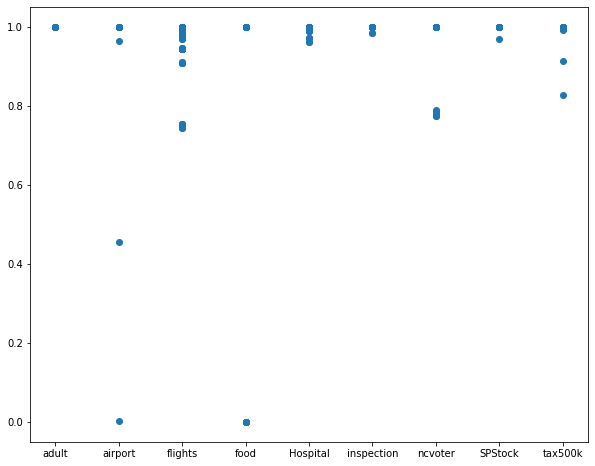

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(dsts,sSups)

In [ ]:
plt.scatter(eSupp,sSupp,5,c=[x if x>0 else 0 for x in rSupp])
plt.xlabel("Expected support")
plt.ylabel("Sample Support")
plt.title("Random DCs by Relative support")
plt.plot([0,0.95,0.95],[0.9,0.98,1.02],c='red')


In [6]:
ds=Dataset("datasets/tax500k.csv")
ds.buildPLIs()

In [16]:
dc=DenialConstraint([Predicate("Zip(String)",eq,"Zip(String)")])
1-dc.expCoverage(ds)

4.53199280000538e-05

In [17]:
dc=DenialConstraint([Predicate("LName(String)",eq,"LName(String)")])
1-dc.expCoverage(ds)

9.999112799996546e-05

In [18]:
dc=DenialConstraint([Predicate("AreaCode(String)",eq,"AreaCode(String)")])
1-dc.expCoverage(ds)

0.008886343111999984

In [20]:
dc=DenialConstraint([Predicate("Gender(String)",eq,"Gender(String)")])
1-dc.expCoverage(ds)

0.500006636168

In [21]:
dc=DenialConstraint([Predicate("State(String)",eq,"State(String)")])
1-dc.expCoverage(ds)

0.019409890831999954

In [8]:
ds.df.columns

Index(['LName(String)', 'Gender(String)', 'AreaCode(String)', 'Phone(String)',
       'City(String)', 'State(String)', 'Zip(String)', 'MaritalStatus(String)',
       'HasChild(String)', 'Rate(Double)', 'SingleExemp(Integer)',
       'MarriedExemp(Integer)', 'ChildExemp(Integer)'],
      dtype='object')

In [10]:
cols=ds.df.columns[[1,3,4,7,8,9,10,12]]
cols

Index(['Gender(String)', 'Phone(String)', 'City(String)',
       'MaritalStatus(String)', 'HasChild(String)', 'Rate(Double)',
       'SingleExemp(Integer)', 'ChildExemp(Integer)'],
      dtype='object')

In [12]:
ops=[eq,eq,eq,eq,ne,ne,eq,ne]
res=1
for col,op in zip(cols,ops):
    dc=DenialConstraint([Predicate(col,op,col)])
    val=1-dc.expCoverage(ds)
    res*=val
    print(val)
print(res)

0.500006636168
0.00025675746400000143
0.0007283229760000065
0.500002657352
0.49999543980000005
0.9376212312159999
0.41205728444800005
0.585904069672
5.2914263528939405e-09
